In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
def import_data(path):
    data = pd.read_csv(path)
    return data

In [10]:
bitcoin_all = import_data('D:\\Studia\\W8\\Praca magisterska\\praca_magisterska\\data\\raw\\BTC-USD.csv')

In [11]:
print(bitcoin_all[bitcoin_all.isnull().any(axis=1)])

            Date  Open  High  Low  Close  Adj Close  Volume
1379  2020-08-04   NaN   NaN  NaN    NaN        NaN     NaN


In [4]:
bitcoin_all = bitcoin_all.dropna() #remove row with at least one NaN

In [12]:
bitcoin_all['Date'] = pd.to_datetime(bitcoin_all['Date'], infer_datetime_format=True)
bitcoin_all = bitcoin_all.set_index('Date')

In [16]:
bitcoin_all = bitcoin_all.interpolate(method='time')
bitcoin_all['2020-08-01': '2020-08-08']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-01,11322.570313,11794.775391,11239.682617,11759.592773,11759.592773,2.607567e+10
2020-08-02,11758.764648,12034.144531,11018.129883,11053.614258,11053.614258,2.741007e+10
2020-08-03,11043.768555,11453.079102,11012.415039,11246.348633,11246.348633,2.027171e+10
2020-08-04,11123.795899,11619.848145,11085.350097,11496.685547,11496.685547,2.234148e+10
2020-08-05,11203.823242,11786.617188,11158.285156,11747.022461,11747.022461,2.441125e+10
2020-08-06,11749.871094,11902.335938,11598.713867,11779.773438,11779.773438,2.340074e+10
2020-08-07,11778.894531,11898.038086,11408.593750,11601.472656,11601.472656,2.313231e+10
2020-08-08,11604.553711,11800.064453,11558.431641,11754.045898,11754.045898,1.757206e+10


In [6]:
data = bitcoin_all[['Close']]
data.columns = ['price']

In [41]:
len(bitcoin_all)

1461

In [34]:
bitcoin_train=bitcoin_all['2016-10-25':'2019-10-31']
bitcoin_test=bitcoin_all['2019-11-01':'2020-10-25']

In [35]:
data_train= bitcoin_train[['Close']]
data_test = bitcoin_test[['Close']]

In [36]:
data_test

,Close
Date,
2019-11-01,9261.104492
2019-11-02,9324.717773
2019-11-03,9235.354492
2019-11-04,9412.612305
2019-11-05,9342.527344
...,...
2020-10-21,12823.689453
2020-10-22,12965.891602
2020-10-23,12931.539063


In [37]:
data_train.columns = ['price']
data_test.columns = ['price']

In [38]:
data_train

,price
Date,
2016-10-25,657.588013
2016-10-26,678.304016
2016-10-27,688.312988
2016-10-28,689.651001
2016-10-29,714.479004
...,...
2019-10-27,9551.714844
2019-10-28,9256.148438
2019-10-29,9427.687500


In [42]:
# define function for create N lags
def create_lags(df, N):
    for i in range(N):
        df['Lag' + str(i+1)] = df.price.shift(i+1)
    return df

In [43]:
number_of_lags = 30

In [44]:
df=create_lags(data_train, number_of_lags)

<ipython-input-42-64024607b302>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lag' + str(i+1)] = df.price.shift(i+1)


In [45]:
df = df.dropna()

In [46]:
df

,price,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag21,Lag22,Lag23,Lag24,Lag25,Lag26,Lag27,Lag28,Lag29,Lag30
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-24,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,751.585022,740.976990,744.197998,711.619019,...,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004,689.651001,688.312988,678.304016,657.588013
2016-11-25,741.648987,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,751.585022,740.976990,744.197998,...,703.234985,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004,689.651001,688.312988,678.304016
2016-11-26,735.382019,741.648987,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,751.585022,740.976990,...,703.418030,703.234985,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004,689.651001,688.312988
2016-11-27,732.034973,735.382019,741.648987,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,751.585022,...,711.521973,703.418030,703.234985,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004,689.651001
2016-11-28,735.812988,732.034973,735.382019,741.648987,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,...,703.130981,711.521973,703.418030,703.234985,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,9551.714844,9244.972656,8660.700195,7493.488770,7514.671875,8078.203125,8243.720703,8222.078125,7988.560547,7973.207520,...,7988.155762,8151.500488,8205.939453,8259.992188,8393.041992,8343.276367,8293.868164,8104.185547,8245.915039,8251.845703
2019-10-28,9256.148438,9551.714844,9244.972656,8660.700195,7493.488770,7514.671875,8078.203125,8243.720703,8222.078125,7988.560547,...,8245.623047,7988.155762,8151.500488,8205.939453,8259.992188,8393.041992,8343.276367,8293.868164,8104.185547,8245.915039
2019-10-29,9427.687500,9256.148438,9551.714844,9244.972656,8660.700195,7493.488770,7514.671875,8078.203125,8243.720703,8222.078125,...,8228.783203,8245.623047,7988.155762,8151.500488,8205.939453,8259.992188,8393.041992,8343.276367,8293.868164,8104.185547


In [47]:
# create X and y
y = df.price.values
X = df.iloc[:, 1:].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [92]:
def fit_best_SVR_model_using_GridSearch(X, y):
    param_grid = {'C': [0.1, 1, 10, 50, 100, 150],
                  'gamma': [1, 0.1, 0.01, 0.001],
                  'kernel': ['rbf']}

    svr_rbf = GridSearchCV(SVR(), param_grid, refit=True, verbose=3)

    # fitting the model for grid search
    svr_rbf.fit(X, y)
    print(f'Chosen parameters: {svr_rbf.best_params_}')
    return svr_rbf

In [93]:
fit_best_SVR_model_using_GridSearch(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-0.001, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-0.003, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-0.002, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-0.004, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-0.012, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-0.001, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-0.003, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-0.002, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-0.004, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-0.012, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] .......... C=50, gamma=1, kernel=rbf, score=-0.002, total=   0.0s
[CV] C=50, gamma=1, kernel=rbf .......................................
[CV] .......... C=50, gamma=1, kernel=rbf, score=-0.004, total=   0.1s
[CV] C=50, gamma=1, kernel=rbf .......................................
[CV] .......... C=50, gamma=1, kernel=rbf, score=-0.012, total=   0.0s
[CV] C=50, gamma=0.1, kernel=rbf .....................................
[CV] ........ C=50, gamma=0.1, kernel=rbf, score=-0.001, total=   0.0s
[CV] C=50, gamma=0.1, kernel=rbf .....................................
[CV] ........ C=50, gamma=0.1, kernel=rbf, score=-0.003, total=   0.0s
[CV] C=50, gamma=0.1, kernel=rbf .....................................
[CV] ........ C=50, gamma=0.1, kernel=rbf, score=-0.002, total=   0.1s
[CV] C=50, gamma=0.1, kernel=rbf .....................................
[CV] ........ C=50, gamma=0.1, kernel=rbf, score=-0.004, total=   0.0s
[CV] C=50, gamma=0.1, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.1s finished


Chosen parameters: {'C': 150, 'gamma': 0.001, 'kernel': 'rbf'}


GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 50, 100, 150],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [89]:
# fit and predict
svr_rbf = SVR(kernel= 'rbf', C= 100, gamma= 0.00000001, epsilon = 0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=100, gamma=1e-08)

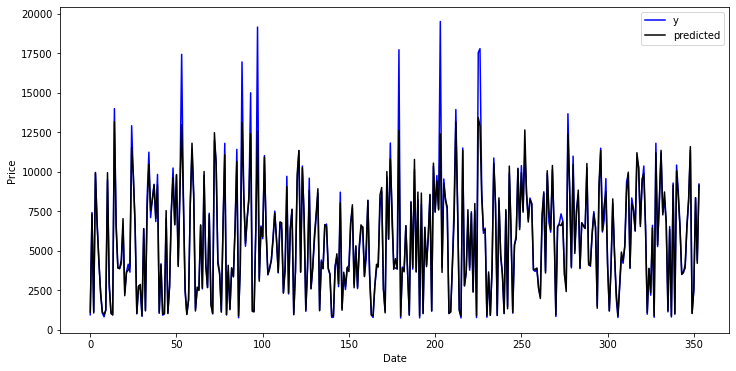

In [28]:
plt.figure(figsize = (12,6))
plt.plot(y_test, color= 'blue', label= 'y')
plt.plot(svr_rbf.predict(X_test), color= 'black', label= 'predicted')

#plt.plot(dates_train, clf.predict(X_test), color= 'red', label= 'RBF model') 
#plt.plot(dates_test, scaler.inverse_transform(svr_rbf.predict(dates_test)), color= 'green', label= 'RBF model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [21]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 500, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001], 
              'kernel': ['rbf']}  
  
svr_rbf = GridSearchCV(SVR(), param_grid, refit = True, verbose = 2) 
  
# fitting the model for grid search 
svr_rbf.fit(svr_rbf.fit(X_train, y_train)) 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .

[CV] .................... C=10, gamma=1e-05, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1e-07, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10, gamma=1e-07, kernel=rbf ...................................
[CV] .

[CV] ................... C=100, gamma=1e-08, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1e-08, kernel=rbf ..................................
[CV] ................... C=100, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1e-08, kernel=rbf ..................................
[CV] ................... C=100, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=500, gamma=1, kernel=rbf ......................................
[CV] ....................... C=500, gamma=1, kernel=rbf, total=   0.1s
[CV] C=500, gamma=1, kernel=rbf ......................................
[CV] ....................... C=500, gamma=1, kernel=rbf, total=   0.1s
[CV] C=500, gamma=1, kernel=rbf ......................................
[CV] ....................... C=500, gamma=1, kernel=rbf, total=   0.1s
[CV] C=500, gamma=1, kernel=rbf ......................................
[CV] ....................... C=500, gamma=1, kernel=rbf, total=   0.1s
[CV] C=500, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ................... C=1000, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=1000, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=1000, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   20.5s finished


TypeError: Singleton array array(GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 500, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                   1e-07, 1e-08],
                         'kernel': ['rbf']},
             verbose=2), dtype=object) cannot be considered a valid collection.

In [52]:
svr_rbf.best_params_

{'C': 1000, 'gamma': 1e-08, 'kernel': 'rbf'}

In [125]:
y[-5:]

array([8243.720703, 8078.203125, 7514.671875, 7493.48877 , 8660.700195])

In [127]:
X[-5:]

array([[ 8222.078125,  7988.560547,  7973.20752 ,  8103.911133,
         8047.526855,  8205.369141,  8374.686523,  8321.005859,
         8336.555664,  8321.756836,  8586.473633,  8595.740234,
         8228.783203,  8245.623047,  7988.155762,  8151.500488,
         8205.939453,  8259.992188,  8393.041992,  8343.276367,
         8293.868164,  8104.185547,  8245.915039,  8251.845703,
         8118.967773,  8486.993164,  8620.566406,  9729.324219,
        10070.392578, 10019.716797],
       [ 8243.720703,  8222.078125,  7988.560547,  7973.20752 ,
         8103.911133,  8047.526855,  8205.369141,  8374.686523,
         8321.005859,  8336.555664,  8321.756836,  8586.473633,
         8595.740234,  8228.783203,  8245.623047,  7988.155762,
         8151.500488,  8205.939453,  8259.992188,  8393.041992,
         8343.276367,  8293.868164,  8104.185547,  8245.915039,
         8251.845703,  8118.967773,  8486.993164,  8620.566406,
         9729.324219, 10070.392578],
       [ 8078.203125,  8243.72

In [126]:
svr_rbf.predict(X[-5:])

array([8243.62062915, 8078.10304545, 7514.57169591, 7493.38918454,
       8660.60048879])

In [170]:
np.append(X[-1][1:], 19).reshape(1, -1)

array([[7514.671875, 8078.203125, 8243.720703, 8222.078125, 7988.560547,
        7973.20752 , 8103.911133, 8047.526855, 8205.369141, 8374.686523,
        8321.005859, 8336.555664, 8321.756836, 8586.473633, 8595.740234,
        8228.783203, 8245.623047, 7988.155762, 8151.500488, 8205.939453,
        8259.992188, 8393.041992, 8343.276367, 8293.868164, 8104.185547,
        8245.915039, 8251.845703, 8118.967773, 8486.993164,   19.      ]])

In [61]:
data_train.index[-1]

Timestamp('2019-10-25 00:00:00')

In [22]:
def predict_future(X, model, days_ahead):
    predicted_y = []
    indexes = []
    last_index = data_train.index[-1]
    for i in range(1, days_ahead+1):
        new_prediction = model.predict(X[-1].reshape(1, -1)) #jeden dzien do przodu
        predicted_y.append(new_prediction)
        X = np.concatenate((X, np.append(X[-1][1:], new_prediction).reshape(1, -1)))
        indexes.append(last_index + pd.Timedelta(days=1))
        last_index = last_index + pd.Timedelta(days=1)
        
    predicted_dataframe = pd.DataFrame({'prices': predicted_y, 'date': indexes})
    predicted_dataframe = predicted_dataframe.set_index('date')
    predicted_dataframe['prices'] = predicted_dataframe['prices'].astype(float)
    return predicted_dataframe

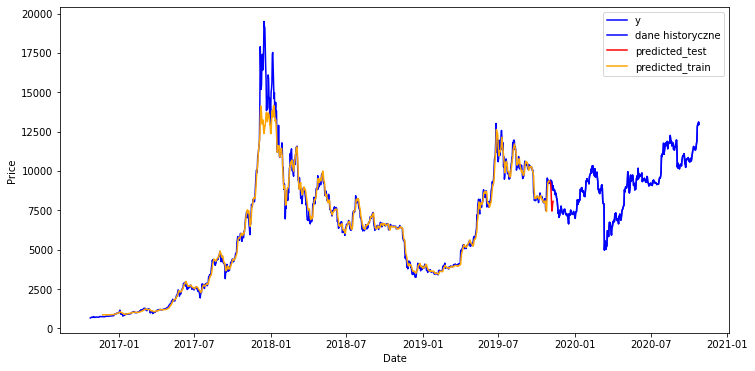

In [54]:
plt.figure(figsize = (12,6))
plt.plot(data_test.price, color= 'blue', label= 'y')
plt.plot(data.price, color= 'blue', label= 'dane historyczne')
plt.plot(predict_future(X,svr_rbf,10).prices, color= 'red', label= 'predicted_test')
plt.plot(data_train.index[number_of_lags:],svr_rbf.predict(X), color= 'orange', label= 'predicted_train')

#plt.plot(dates_train, clf.predict(X_test), color= 'red', label= 'RBF model') 
#plt.plot(dates_test, scaler.inverse_transform(svr_rbf.predict(dates_test)), color= 'green', label= 'RBF model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
#plt.savefig('D://Studia//W8//Praca magisterska//30lag-30days-prediction.png')
plt.show()

In [24]:
score = svr_rbf.score(X,y)
print("R-squared:", score)
print("MSE:", mean_squared_error(y, svr_rbf.predict(X)))


R-squared: 0.9693787586233985
MSE: 415764.2114978366


In [58]:
data_test.price.tail(10)

Date
2020-10-16    11322.123047
2020-10-17    11358.101563
2020-10-18    11483.359375
2020-10-19    11742.037109
2020-10-20    11916.334961
2020-10-21    12823.689453
2020-10-22    12965.891602
2020-10-23    12931.539063
2020-10-24    13108.062500
2020-10-25    12956.892578
Name: price, dtype: float64

In [84]:
predict_future(X,svr_rbf,10)

,prices
date,
2019-10-26,7435.532592
2019-10-27,7837.530888
2019-10-28,7967.050253
2019-10-29,8130.350672
2019-10-30,8011.857214
2019-10-31,7994.211149
2019-11-01,8050.661484
2019-11-02,8103.133483
2019-11-03,8202.290639


In [82]:
predicted['prices'].astype(float)

date
2019-10-26    7435.532592
2019-10-27    7837.530888
2019-10-28    7967.050253
2019-10-29    8130.350672
2019-10-30    8011.857214
2019-10-31    7994.211149
2019-11-01    8050.661484
2019-11-02    8103.133483
2019-11-03    8202.290639
2019-11-04    8386.149222
Name: prices, dtype: float64

In [109]:
svr_rbf.predict(X)[-1]

8660.600488794269

In [110]:
y[-1]

8660.700195

In [6]:
# create fake temperature
df = pd.DataFrame({'temp':np.random.rand(500)})

# define function for create N lags
def create_lags(df, N):
    for i in range(N):
        df['Lag' + str(i+1)] = df.temp.shift(i+1)
    return df

# create 10 lags
df = create_lags(df,10)

# the first 10 days will have missing values. can't use them.
df = df.dropna()

# create X and y
y = df.temp.values
X = df.iloc[:, 1:].values

# Train on 70% of the data
train_idx = int(len(df) * .7)

# create train and test data
X_train, y_train, X_test, y_test = X[:train_idx], y[:train_idx], X[train_idx:], y[:train_idx]

# fit and predict
clf = SVR()
clf.fit(X_train, y_train)

clf.predict(X_test)

In [8]:
# the first 10 days will have missing values. can't use them.
df = df.dropna()

In [55]:
df

,price,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag21,Lag22,Lag23,Lag24,Lag25,Lag26,Lag27,Lag28,Lag29,Lag30
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-24,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,751.585022,740.976990,744.197998,711.619019,...,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004,689.651001,688.312988,678.304016,657.588013
2016-11-25,741.648987,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,751.585022,740.976990,744.197998,...,703.234985,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004,689.651001,688.312988,678.304016
2016-11-26,735.382019,741.648987,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,751.585022,740.976990,...,703.418030,703.234985,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004,689.651001,688.312988
2016-11-27,732.034973,735.382019,741.648987,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,751.585022,...,711.521973,703.418030,703.234985,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004,689.651001
2016-11-28,735.812988,732.034973,735.382019,741.648987,740.289001,744.593994,751.346985,739.247986,731.026001,751.616028,...,703.130981,711.521973,703.418030,703.234985,688.700012,740.828979,729.793030,700.971985,701.864014,714.479004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-21,8243.720703,8222.078125,7988.560547,7973.207520,8103.911133,8047.526855,8205.369141,8374.686523,8321.005859,8336.555664,...,8293.868164,8104.185547,8245.915039,8251.845703,8118.967773,8486.993164,8620.566406,9729.324219,10070.392578,10019.716797
2019-10-22,8078.203125,8243.720703,8222.078125,7988.560547,7973.207520,8103.911133,8047.526855,8205.369141,8374.686523,8321.005859,...,8343.276367,8293.868164,8104.185547,8245.915039,8251.845703,8118.967773,8486.993164,8620.566406,9729.324219,10070.392578
2019-10-23,7514.671875,8078.203125,8243.720703,8222.078125,7988.560547,7973.207520,8103.911133,8047.526855,8205.369141,8374.686523,...,8393.041992,8343.276367,8293.868164,8104.185547,8245.915039,8251.845703,8118.967773,8486.993164,8620.566406,9729.324219


In [10]:
# create X and y
y = df.temp.values
X = df.iloc[:, 1:].values

In [14]:
# Train on 70% of the data
train_idx = int(len(df) * .7)

In [17]:
# create train and test data
X_train, y_train, X_test, y_test = X[:train_idx], y[:train_idx], X[train_idx:], y[:train_idx]

In [22]:
# fit and predict
clf = SVR()
clf.fit(X_train, y_train)

array([0.46158503, 0.46875159, 0.44602146, 0.5762939 , 0.377501  ,
       0.51826102, 0.51703843, 0.61186234, 0.28899909, 0.50739331,
       0.37709487, 0.43382975, 0.72113034, 0.49824496, 0.35976999,
       0.48259006, 0.48247522, 0.64123523, 0.46080899, 0.28225957,
       0.59013569, 0.47832269, 0.64236991, 0.39722139, 0.03951015,
       0.54155821, 0.49669199, 0.43853613, 0.72962722, 0.50698428,
       0.46881281, 0.33942275, 0.40216769, 0.50504864, 0.41460561,
       0.63913356, 0.72014274, 0.46367334, 0.63909514, 0.61494089,
       0.60076307, 0.50645809, 0.58263887, 0.68280547, 0.40822085,
       0.68580924, 0.6085437 , 0.43674566, 0.49995661, 0.12209687,
       0.4502621 , 0.56398731, 0.56622988, 0.3168852 , 0.39323731,
       0.29382805, 0.55374869, 0.57463992, 0.46924677, 0.64145881,
       0.57297036, 0.45401438, 0.35291227, 0.32128776, 0.41063453,
       0.25246949, 0.50096862, 0.65452571, 0.29748284, 0.4497943 ,
       0.39281235, 0.75252637, 0.47585059, 0.48702891, 0.54269